In [1]:
import datasets
from model import MLPClassifier, MLPConfig

/home/vcivale/scImmulogyClassifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = datasets.load_from_disk(
    "/equilibrium/datasets/TCGA-histological-data/scImmunology/dataset_v3"
)

In [3]:
model_path = "/equilibrium/datasets/TCGA-histological-data/scFoundationEmbeddings_Detailed_Clusters/hierarchical_model/final_model_All_cells_MLPClassifier_hdim_3072x1536x768_2025-09-22_09-52-20"


model = MLPClassifier.from_pretrained(model_path)

In [4]:
model.eval()

MLPClassifier(
  (input_bn): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_network): Sequential(
    (0): MLPBlock(
      (linear): Linear(in_features=3072, out_features=3072, bias=True)
      (bn): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): MLPBlock(
      (linear): Linear(in_features=3072, out_features=1536, bias=True)
      (bn): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): MLPBlock(
      (linear): Linear(in_features=1536, out_features=768, bias=True)
      (bn): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (output

In [5]:
id2label= { 0: "B cells",
    1: "CD4+ T cells",
    2: "DN T cells",
    3: "MAIT cells",
    4: "Myeloid cells",
    5: "NK cells",
    6: "Progenitor cells",
    7: "TRAV1-2- CD8+ T cells",
    8: "gd T cells"
  }

label2id= { v: k for k, v in id2label.items() }

In [7]:

# Prepara il test set
test_dataset = dataset['test']

test_dataset = test_dataset.rename_column("embedding", "input_ids")
test_dataset = test_dataset.rename_column("Cluster_names", "labels")

# Mappa le etichette stringa agli ID numerici usando .map sul dataset
def label_to_id(example):
	return {"labels": label2id[example["labels"]]}

test_dataset = test_dataset.map(label_to_id)

# Assicurati che il formato sia corretto
test_dataset.set_format(type='torch', columns=['input_ids', 'labels'])

Map: 100%|██████████| 191637/191637 [02:01<00:00, 1578.35 examples/s]


In [8]:
import numpy as np
from transformers import Trainer, TrainingArguments

# Non sono necessari argomenti di training per la sola predizione,
# ma l'oggetto TrainingArguments è richiesto dal Trainer.
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=64 # Aumenta se hai abbastanza VRAM
)

# Inizializza il Trainer solo con il modello
trainer = Trainer(
    model=model,
    args=training_args,
)

# Esegui la predizione sul test set
predictions_output = trainer.predict(test_dataset)

# Le predizioni grezze (logits) sono in predictions_output.predictions
logits = predictions_output.predictions

# Converti i logits nella classe predetta (quella con il valore più alto)
predicted_labels = np.argmax(logits, axis=1)

# Le etichette vere sono in predictions_output.label_ids
true_labels = predictions_output.label_ids

/home/vcivale/scImmulogyClassifier/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
true_labels

array([1, 8, 7, ..., 1, 7, 4], shape=(191637,))

In [10]:
import evaluate

# Carica le metriche che ti interessano
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Calcola i risultati
accuracy = accuracy_metric.compute(predictions=predicted_labels, references=true_labels)
# Per problemi multi-classe, è bene specificare un tipo di media, 'weighted' tiene
# conto dello sbilanciamento delle classi.
f1_score = f1_metric.compute(predictions=predicted_labels, references=true_labels, average="weighted")

print(f"Accuracy sul Test Set: {accuracy['accuracy']:.4f}")
print(f"F1-Score (Weighted) sul Test Set: {f1_score['f1']:.4f}")

# Per un report più dettagliato, usa classification_report di scikit-learn
from sklearn.metrics import classification_report

# Avrai bisogno dei nomi delle classi per leggere il report
# Li puoi ottenere dalla configurazione del modello o dal dataset
class_names = model.config.id2label.values() # o dal dataset: test_dataset.features['labels'].names

print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Accuracy sul Test Set: 0.9195
F1-Score (Weighted) sul Test Set: 0.9194

--- Classification Report ---
                       precision    recall  f1-score   support

              B cells       1.00      1.00      1.00      7162
         CD4+ T cells       0.95      0.96      0.96     90115
           DN T cells       0.58      0.87      0.70       149
           MAIT cells       0.94      0.95      0.95      2424
        Myeloid cells       0.91      0.91      0.91     33693
             NK cells       0.86      0.84      0.85     20547
     Progenitor cells       0.99      0.99      0.99       180
TRAV1-2- CD8+ T cells       0.87      0.85      0.86     31335
           gd T cells       0.87      0.85      0.86      6032

             accuracy                           0.92    191637
            macro avg       0.88      0.92      0.90    191637
         weighted avg       0.92      0.92      0.92    191637



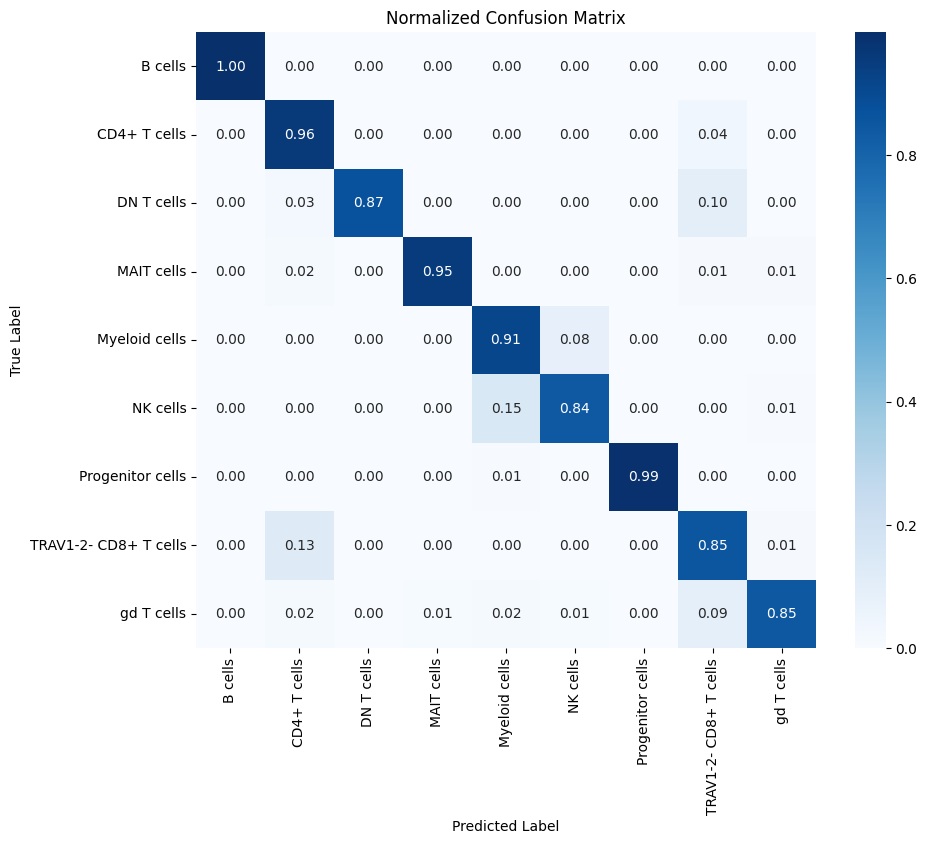

In [14]:
# normalized confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=class_names
              , yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()